# Author: Gunārs Ābeltiņš, ga22008

## Control

In [1]:
# If TRAIN set to True will train finetuned model for one epoch
TRAIN = False
# If TEST set to True will test finetuned model against original and depending on TRAIN value
# True: will test just trained model
# False: will test model that's been previosly trained for 3 epochs and saved in online storage
TEST = True

FINETUNED_MODEL_URL = "https://dl.dropbox.com/scl/fi/qy8w4sj6x3d354lgrbx92/steam_reviews_model.zip?rlkey=7rtiys8ydjzu3t1ivrwqgsi8e&st=j1vpclup&dl=1"

FINETUNED_MODEL_PATH = './steam_reviews_model'

TEST_DATA_PATH = '../input/steam-reviews/dataset_top20_cleaned.csv'

## Training

In [2]:
import sys
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.nn import DataParallel

class SteamReviewsDataset(Dataset):
    """
    Custom PyTorch Dataset for Steam reviews classification.
    
    Handles the conversion of text reviews to tokenized inputs for the model
    and maps the review scores to binary classification labels.
    """
    def __init__(self, reviews, scores, tokenizer, max_length=128):
        """
        Initialize the dataset.
        
        Args:
            reviews (list): List of review text strings
            scores (list): List of review scores (-1 for negative, 1 for positive)
            tokenizer: DistilBert tokenizer instance
            max_length (int): Maximum sequence length for tokenization
        """
        self.reviews = reviews
        self.scores = scores
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.scores)
    
    def __getitem__(self, idx):
        """
        Get a single tokenized review and its corresponding label.
        
        Args:
            idx (int): Index of the review
            
        Returns:
            tuple: (tokenized_inputs, label)
                - tokenized_inputs: Dictionary with input_ids, attention_mask
                - label: Binary tensor (0 for negative, 1 for positive)
        """
        review_text = str(self.reviews[idx])
        
        # Tokenize the text
        encoding = self.tokenizer(
            review_text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        # Remove the batch dimension added by the tokenizer
        encoding = {k: v.squeeze(0) for k, v in encoding.items()}
        
        # Convert -1/1 to 0/1 for binary classification
        label = torch.tensor(1 if self.scores[idx] == 1 else 0, dtype=torch.long)
        
        return encoding, label

def load_and_preprocess_data(file_path):
    """
    Load and preprocess the Steam reviews data.
    
    Args:
        file_path (str): Path to the TSV file containing the reviews
        
    Returns:
        DataFrame: Preprocessed pandas DataFrame with reviews
    """
    # Load the TSV file
    df = pd.read_csv(file_path, sep='\t')
    
    # Display dataset info
    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    # Clean the data
    df = df.dropna(subset=['review_text', 'review_score'])
    
    # Display class distribution
    print(f"Positive reviews: {(df['review_score'] == 1).sum()}")
    print(f"Negative reviews: {(df['review_score'] == -1).sum()}")
    
    return df

def train_distilbert_for_review_classification(
    data_path,
    model_name="distilbert-base-uncased-finetuned-sst-2-english",
    batch_size=32,
    epochs=3,
    learning_rate=2e-5,
    max_length=128,
    train_size=0.8,
    random_state=42,
    manual_seed=22
):
    """
    Fine-tune DistilBERT model on Steam reviews dataset.
    
    Args:
        data_path (str): Path to the dataset file
        model_name (str): HuggingFace model name to use
        batch_size (int): Training batch size
        epochs (int): Number of training epochs
        learning_rate (float): Learning rate for optimizer
        max_length (int): Maximum sequence length for tokenization
        train_size (float): Proportion of data to use for training
        random_state (int): Random seed for data splitting
        manual_seed (int): Random seed for PyTorch reproducibility
        
    Returns:
        tuple: (model, tokenizer, training_stats)
            - model: Trained DistilBERT model
            - tokenizer: Tokenizer used with the model
            - training_stats: Dictionary with training statistics
    """
    # Set device for training (GPU if available, otherwise CPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")

    # Set manual seed for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(manual_seed)
    
    # Load and preprocess data
    df = load_and_preprocess_data(data_path)
    
    # Split data into training and validation sets
    train_df, val_df = train_test_split(
        df, 
        train_size=train_size, 
        random_state=random_state,
        stratify=df['review_score']  # Maintain class distribution
    )
    
    print(f"Training samples: {len(train_df)}")
    print(f"Validation samples: {len(val_df)}")
    
    # Load pre-trained tokenizer and model
    tokenizer = DistilBertTokenizer.from_pretrained(model_name)
    model = DistilBertForSequenceClassification.from_pretrained(model_name)
    
    # Check if multi-GPU training is possible
    multi_gpu = torch.cuda.device_count() > 1
    
    # Wrap model with DataParallel if multiple GPUs are available
    if multi_gpu:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        model = DataParallel(model)
    
    # Move model to device (GPU or CPU)
    model.to(device)
    
    # Create datasets for training and validation
    train_dataset = SteamReviewsDataset(
        train_df['review_text'].tolist(),
        train_df['review_score'].tolist(),
        tokenizer,
        max_length=max_length
    )
    
    val_dataset = SteamReviewsDataset(
        val_df['review_text'].tolist(),
        val_df['review_score'].tolist(),
        tokenizer,
        max_length=max_length
    )
    
    # Create data loaders with parallel loading
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        num_workers=2
    )
    
    # Define optimizer with weight decay
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    
    # Initialize tracking variables for training statistics
    training_stats = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}
    
    # Training loop
    for epoch in range(epochs):
        # ===== Training phase =====
        model.train()
        train_loss = 0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]", file=sys.stdout)
        for batch_idx, (batch_inputs, batch_labels) in enumerate(progress_bar):
            # Move data to device
            batch_labels = batch_labels.to(device)
            batch_inputs = {k: v.to(device) for k, v in batch_inputs.items()}
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(**batch_inputs)
            logits = outputs.logits
            
            # Get the correct number of labels based on whether we're using DataParallel
            num_labels = model.module.config.num_labels if multi_gpu else model.config.num_labels
            
            # Calculate loss manually
            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, num_labels), batch_labels.view(-1))
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Update stats
            train_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})
            
        # ===== Validation phase =====
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():  # No gradients needed for validation
            progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]")
            for batch_idx, (batch_inputs, batch_labels) in enumerate(progress_bar):
                # Move data to device
                batch_labels = batch_labels.to(device)
                batch_inputs = {k: v.to(device) for k, v in batch_inputs.items()}
                
                # Forward pass
                outputs = model(**batch_inputs)
                logits = outputs.logits
                
                # Get the correct number of labels based on whether we're using DataParallel
                num_labels = model.module.config.num_labels if multi_gpu else model.config.num_labels
                
                # Calculate loss manually
                loss_fct = torch.nn.CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, num_labels), batch_labels.view(-1))
                val_loss += loss.item()
                
                # Calculate accuracy
                predictions = torch.argmax(logits, dim=1)
                correct += (predictions == batch_labels).sum().item()
                total += batch_labels.size(0)
                
                progress_bar.set_postfix({'loss': loss.item(), 'accuracy': correct/total})
        
        # Compute epoch stats
        epoch_train_loss = train_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_accuracy = correct / total
        
        # Update training stats
        training_stats['train_loss'].append(epoch_train_loss)
        training_stats['val_loss'].append(epoch_val_loss)
        training_stats['val_accuracy'].append(epoch_val_accuracy)
        
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train loss: {epoch_train_loss:.4f}, "
              f"Val loss: {epoch_val_loss:.4f}, "
              f"Val accuracy: {epoch_val_accuracy:.4f}")
    
    print("Training complete!")
    
    # If we used DataParallel, get the underlying model for saving
    if multi_gpu:
        model_to_save = model.module
    else:
        model_to_save = model
    
    return model_to_save, tokenizer, training_stats

if TRAIN == True:
    # Train the model
    model, tokenizer, stats = train_distilbert_for_review_classification(
        data_path=TEST_DATA_PATH,
        batch_size=32,  # Increased batch size for multi-GPU
        epochs=1,
        learning_rate=2e-5,
        max_length=128
    )
    
    # Save the model and tokenizer
    model.save_pretrained(FINETUNED_MODEL_PATH)
    tokenizer.save_pretrained(FINETUNED_MODEL_PATH)
    
    # Plot training stats
    import matplotlib.pyplot as plt
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss curves
    ax1.plot(stats['train_loss'], label='Training loss')
    ax1.plot(stats['val_loss'], label='Validation loss')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot accuracy curve
    ax2.plot(stats['val_accuracy'], label='Validation accuracy')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

## Testing

Extracting model files...
Running model comparison...
Using device: cuda
Available GPUs: 2
Loading test data...
Test dataset size: 1000
Positive reviews: 891
Negative reviews: 109
Loading original model...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Using 2 GPUs with DataParallel!
Loading fine-tuned model...
Using 2 GPUs with DataParallel!
Evaluating original model...


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating fine-tuned model...


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]


--- Performance Comparison ---
Metric     | Original   | Fine-tuned | Difference
-----------------------------------------------
accuracy   | 0.7750    | 0.9820    | 0.2070 (+20.70%)
precision  | 0.9757    | 0.9921    | 0.0164 (+1.64%)
recall     | 0.7666    | 0.9877    | 0.2211 (+22.11%)
f1         | 0.8586    | 0.9899    | 0.1313 (+13.13%)


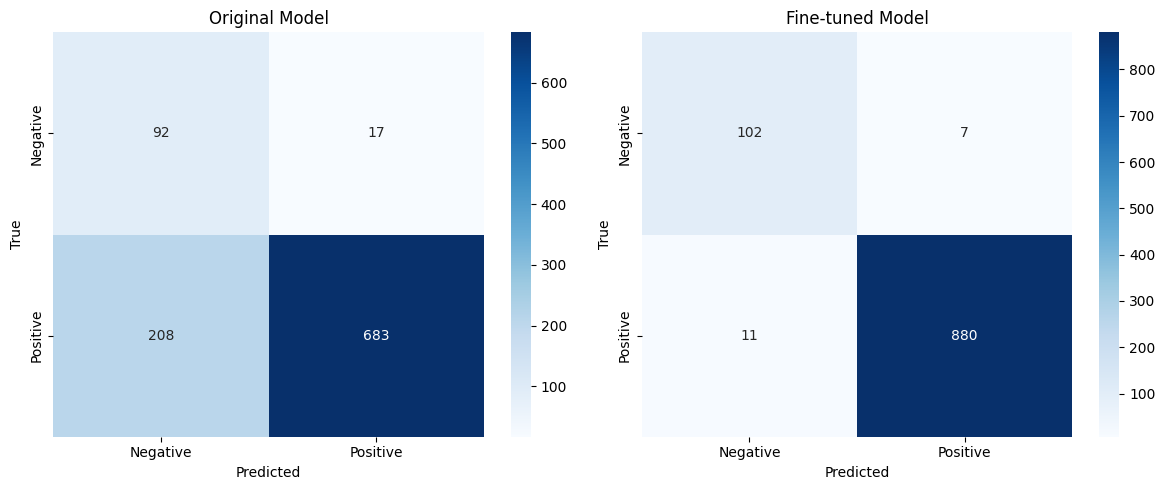


Found 217 examples where models disagree

In disagreement cases:
- Fine-tuned: 212 (97.70%)
- Original: 5 (2.30%)

Examples of disagreements (random sample):

EXAMPLE 154:
----------------------------------------------------------------------------------------------------
REVIEW TEXT:
JUST PLAY THE GGGGAAAAMMMMEEEE WHO CARES ABOUT ME PLAY IIIIIIIIIITTTTTT
----------------------------------------------------------------------------------------------------
TRUE LABEL: Positive
ORIGINAL MODEL PREDICTION: Negative
FINE-TUNED MODEL PREDICTION: Positive
CORRECT MODEL: Fine-tuned


EXAMPLE 90:
----------------------------------------------------------------------------------------------------
REVIEW TEXT:
Killed the final boss with a broken sword - 10/10 would suffer through all that pain again
----------------------------------------------------------------------------------------------------
TRUE LABEL: Positive
ORIGINAL MODEL PREDICTION: Negative
FINE-TUNED MODEL PREDICTION: Positive
CORR

In [3]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import requests
import zipfile
import textwrap
import os

def test_and_compare_models(
    test_data_path,
    original_model_name="distilbert/distilbert-base-uncased-finetuned-sst-2-english",
    finetuned_model_path="./steam_reviews_model",
    batch_size=32,
    max_length=128,
    num_samples=None  # Set to a number if you want to use a subset of test data
):
    """
    Load both the original and fine-tuned models, test them on the same dataset,
    and compare their performance.
    
    Args:
        test_data_path (str): Path to the test dataset CSV/TSV file
        original_model_name (str): HuggingFace model name for the original model
        finetuned_model_path (str): Path to the saved fine-tuned model
        batch_size (int): Batch size for testing
        max_length (int): Maximum sequence length for tokenization
        num_samples (int, optional): Number of samples to use from test set
        
    Returns:
        dict: Performance metrics for both models with keys 'original' and 'finetuned'
              Each contains accuracy, precision, recall, f1, confusion_matrix, 
              predictions, and labels
    """
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    if torch.cuda.is_available():
        print(f"Available GPUs: {torch.cuda.device_count()}")
        
    # Load and prepare test data
    print("Loading test data...")
    df = pd.read_csv(test_data_path, sep='\t')
    df = df.dropna(subset=['review_text', 'review_score'])
    
    # Optionally use a subset of data
    if num_samples is not None and num_samples < len(df):
        df = df.sample(n=num_samples, random_state=42)
    
    # Print dataset statistics
    print(f"Test dataset size: {len(df)}")
    print(f"Positive reviews: {(df['review_score'] == 1).sum()}")
    print(f"Negative reviews: {(df['review_score'] == -1).sum()}")
    
    # Create test dataset class
    class TestDataset(Dataset):
        """Dataset class for sentiment analysis test data"""
        def __init__(self, reviews, scores, tokenizer, max_length=128):
            """
            Initialize the test dataset
            
            Args:
                reviews (list): List of review texts
                scores (list): List of sentiment scores (-1 for negative, 1 for positive)
                tokenizer: The tokenizer for the model
                max_length (int): Maximum sequence length for tokenization
            """
            self.reviews = reviews
            self.scores = scores
            self.tokenizer = tokenizer
            self.max_length = max_length
            
        def __len__(self):
            return len(self.scores)
        
        def __getitem__(self, idx):
            """Get a tokenized review and its label"""
            review_text = str(self.reviews[idx])
            
            # Tokenize the text
            encoding = self.tokenizer(
                review_text,
                truncation=True,
                padding='max_length',
                max_length=self.max_length,
                return_tensors='pt'
            )
            
            # Remove the batch dimension added by the tokenizer
            encoding = {k: v.squeeze(0) for k, v in encoding.items()}
            
            # Convert -1/1 to 0/1 for binary classification
            label = torch.tensor(1 if self.scores[idx] == 1 else 0, dtype=torch.long)
            
            return encoding, label
    
    # Load models and tokenizers
    print("Loading original model...")
    original_tokenizer = DistilBertTokenizer.from_pretrained(original_model_name)
    original_model = DistilBertForSequenceClassification.from_pretrained(original_model_name)
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs with DataParallel!")
        original_model = torch.nn.DataParallel(original_model)
    original_model.to(device)
    original_model.eval()
    
    print("Loading fine-tuned model...")
    finetuned_tokenizer = DistilBertTokenizer.from_pretrained(finetuned_model_path)
    finetuned_model = DistilBertForSequenceClassification.from_pretrained(finetuned_model_path)
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs with DataParallel!")
        finetuned_model = torch.nn.DataParallel(finetuned_model)
    finetuned_model.to(device)
    finetuned_model.eval()
    
    # Create test datasets and dataloaders
    reviews = df['review_text'].tolist()
    scores = df['review_score'].tolist()
    
    original_test_dataset = TestDataset(
        reviews, scores, original_tokenizer, max_length=max_length
    )
    
    finetuned_test_dataset = TestDataset(
        reviews, scores, finetuned_tokenizer, max_length=max_length
    )
    
    original_test_loader = DataLoader(
        original_test_dataset, batch_size=batch_size
    )
    
    finetuned_test_loader = DataLoader(
        finetuned_test_dataset, batch_size=batch_size
    )
    
    # Define evaluation function
    def evaluate_model(model, test_loader):
        """
        Evaluate a model on the test dataset
        
        Args:
            model: The model to evaluate
            test_loader: DataLoader with test data
            
        Returns:
            dict: Dictionary with performance metrics
        """
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch_inputs, batch_labels in tqdm(test_loader, desc="Evaluating"):
                # Move inputs to device
                batch_labels = batch_labels.to(device)
                batch_inputs = {k: v.to(device) for k, v in batch_inputs.items()}
                
                # Forward pass
                outputs = model(**batch_inputs)
                logits = outputs.logits
                
                # Get predictions
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                
                # Store predictions and labels
                all_preds.extend(preds)
                all_labels.extend(batch_labels.cpu().numpy())
        
        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average='binary'
        )
        conf_matrix = confusion_matrix(all_labels, all_preds)
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'confusion_matrix': conf_matrix,
            'predictions': all_preds,
            'labels': all_labels
        }
    
    # Evaluate both models
    print("Evaluating original model...")
    original_metrics = evaluate_model(original_model, original_test_loader)
    
    print("Evaluating fine-tuned model...")
    finetuned_metrics = evaluate_model(finetuned_model, finetuned_test_loader)
    
    # Print performance comparison
    print("\n--- Performance Comparison ---")
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    
    print(f"{'Metric':<10} | {'Original':<10} | {'Fine-tuned':<10} | {'Difference':<10}")
    print("-" * 47)
    
    for metric in metrics:
        orig_val = original_metrics[metric]
        ft_val = finetuned_metrics[metric]
        diff = ft_val - orig_val
        diff_str = f"{diff:.4f} ({'+' if diff > 0 else ''}{diff*100:.2f}%)"
        
        print(f"{metric:<10} | {orig_val:.4f}    | {ft_val:.4f}    | {diff_str}")
    
    # Plot confusion matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    sns.heatmap(original_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=ax1)
    ax1.set_title('Original Model')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('True')
    
    sns.heatmap(finetuned_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=ax2)
    ax2.set_title('Fine-tuned Model')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('True')
    
    plt.tight_layout()
    plt.show()
    
    # Analyze examples where models disagree
    original_preds = np.array(original_metrics['predictions'])
    finetuned_preds = np.array(finetuned_metrics['predictions'])
    true_labels = np.array(original_metrics['labels'])
    
    # Find indices where models disagree
    disagreement_indices = np.where(original_preds != finetuned_preds)[0]
    
    # Analyze disagreement cases if they exist
    if len(disagreement_indices) > 0:
        print(f"\nFound {len(disagreement_indices)} examples where models disagree")
        
        # Create dataframe with disagreement examples
        disagreement_df = pd.DataFrame({
            'review_text': [df['review_text'].iloc[i] for i in disagreement_indices],
            'true_label': ['Positive' if true_labels[i] == 1 else 'Negative' for i in disagreement_indices],
            'original_pred': ['Positive' if original_preds[i] == 1 else 'Negative' for i in disagreement_indices],
            'finetuned_pred': ['Positive' if finetuned_preds[i] == 1 else 'Negative' for i in disagreement_indices],
            'correct_model': [
                'Both Wrong' if (original_preds[i] != true_labels[i] and finetuned_preds[i] != true_labels[i]) 
                else 'Both Correct' if (original_preds[i] == true_labels[i] and finetuned_preds[i] == true_labels[i])
                else 'Fine-tuned' if finetuned_preds[i] == true_labels[i]
                else 'Original'
                for i in disagreement_indices
            ]
        })
    
        # Count cases where each model was correct
        correct_counts = disagreement_df['correct_model'].value_counts()
        print("\nIn disagreement cases:")
        for model, count in correct_counts.items():
            print(f"- {model}: {count} ({count/len(disagreement_indices)*100:.2f}%)")
        
        # Configure display options for better text wrapping
        pd.set_option('display.max_colwidth', None)
        pd.set_option('display.width', 1000)
        
        # Display examples with improved formatting
        print("\nExamples of disagreements (random sample):")
        sample_size = min(5, len(disagreement_df))
        
        # Print sample examples with clear formatting
        for idx, row in disagreement_df.sample(sample_size).iterrows():
            print("\n" + "="*100)
            print(f"EXAMPLE {idx+1}:")
            print("-"*100)
            print(f"REVIEW TEXT:\n{textwrap.fill(row['review_text'], width=100)}")
            print("-"*100)
            print(f"TRUE LABEL: {row['true_label']}")
            print(f"ORIGINAL MODEL PREDICTION: {row['original_pred']}")
            print(f"FINE-TUNED MODEL PREDICTION: {row['finetuned_pred']}")
            print(f"CORRECT MODEL: {row['correct_model']}")
            print("="*100 + "\n")
        
        # Reset pandas options
        pd.reset_option('display.max_colwidth')
        pd.reset_option('display.width')
    else:
        print("\nNo disagreements found between the models.")
    
    # Return metrics for both models
    return {
        'original': original_metrics,
        'finetuned': finetuned_metrics
    }

if TEST == True:
    if TRAIN == False:
        # Download the model if needed
        print("Downloading fine-tuned model...")
        response = requests.get(FINETUNED_MODEL_URL)
        with open('steam_reviews_model.zip', 'wb') as f:
            f.write(response.content)
        
        # Extract the model files
        print("Extracting model files...")
        with zipfile.ZipFile('steam_reviews_model.zip', "r") as zip_ref:
            zip_ref.extractall(FINETUNED_MODEL_PATH)
    
    # Test and compare models
    print("Running model comparison...")
    results = test_and_compare_models(
        test_data_path=TEST_DATA_PATH,
        finetuned_model_path=FINETUNED_MODEL_PATH,
        batch_size=32,
        num_samples=1000
    )